<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

numpy      : 1.18.5
scipy      : 1.5.0
pandas     : 1.0.5
matplotlib : 3.2.2
statsmodels: 0.11.1
sklearn    : 0.23.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores   : 4
Architecture: 64bit

Git hash: 40630547c3a22e6906cd65a4132f6f602914b368



In [134]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm_notebook

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14063, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs = -1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
print(round(cross_val_score(knn, X_valid, y_valid, cv = skf).mean(), 3))
print(round(knn.fit(X_train, y_train).score(X_valid, y_valid), 3))

0.502
0.588


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, random_state = 17)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
%%time
round(forest.fit(X_train, y_train).score(X_valid, y_valid), 3)

Wall time: 10.7 s


0.729

In [16]:
# write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
#                      'answer4_2.txt')

In [17]:
# !cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [19]:
logit = LogisticRegression(n_jobs = -1)

In [20]:
logit.fit(X_train, y_train).score(X_valid, y_valid)

0.7750651813225883

In [21]:
logit_cvs = cross_val_score(logit, X_train, y_train, cv = skf, n_jobs = -1)
logit_cvs.mean()

0.7606664733822538

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [22]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, 
                                            multi_class = 'multinomial', 
                                            cv = skf,
                                            random_state = 17, 
                                            n_jobs = -1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 25.8 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [23]:
logit_mean_cv_scores1 = list()

# прохід по всім C
for idx, C in enumerate(logit_grid_searcher1.Cs_):
    scores = list()
    # прохід по словнику оцінок класів для отримання середнього по всім класам
    for k, v in logit_grid_searcher1.scores_.items():
        scores.append(np.mean([v[i][idx] for i in range(skf.n_splits)]))
    # додаємо середню оцінку по класам для певного C
    logit_mean_cv_scores1.append(np.mean(scores))

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [24]:
# прохід по всім C
for idx, C in enumerate(logit_grid_searcher1.Cs_):
    scores = list()
    # прохід по словнику оцінок класів для отримання максимального по всім класам
    for k, v in logit_grid_searcher1.scores_.items():
        scores.append(np.max([v[i][idx] for i in range(skf.n_splits)]))
    # додаємо макс оцінку по класам для певного C
    print(f"{round(C, 4)}: {np.mean(scores)}")

0.0001: 0.33739713501981106
0.0005: 0.48110907982937234
0.0022: 0.5621572212065813
0.01: 0.6547836684948203
0.0464: 0.7221206581352834
0.2154: 0.7576958244437673
1.0: 0.7619628162145686
4.6416: 0.7656202377323986
21.5443: 0.7549527583053947
100.0: 0.7488570557756782


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

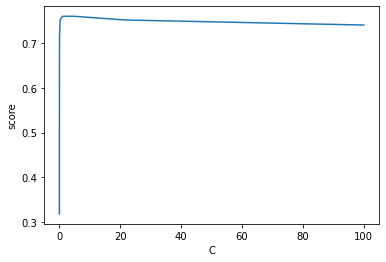

In [25]:
ax = sns.lineplot(logit_c_values1, logit_mean_cv_scores1);
ax.set_xlabel("C")
ax.set_ylabel("score");

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [26]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, 
                                            multi_class = 'multinomial', 
                                            cv = skf,
                                            random_state = 17, 
                                            n_jobs = -1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 11s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [27]:
logit_mean_cv_scores2 = list()

# прохід по всім C
for idx, C in enumerate(logit_grid_searcher2.Cs_):
    scores = list()
    # прохід по словнику оцінок класів для отримання середнього по всім класам
    for k, v in logit_grid_searcher2.scores_.items():
        scores.append(np.mean([v[i][idx] for i in range(skf.n_splits)]))
    # додаємо середню оцінку по класам для певного C
    logit_mean_cv_scores2.append(np.mean(scores))

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [28]:
logit_max_cv_score2 = max(logit_mean_cv_scores2)
logit_max_cv_C2 = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.index(logit_max_cv_score2)]

print(f"Best C: {logit_max_cv_C2}. Score: {logit_max_cv_score2}")

Best C: 1.5526315789473686. Score: 0.7615809216273803


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

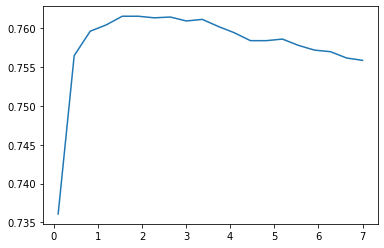

In [29]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [30]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7774354112348898

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [31]:
cv_score = cross_val_score(logit_grid_searcher2, X_train, y_train, cv = skf).mean()
valid_score = logit_grid_searcher2.score(X_valid, y_valid)
print(f"{round(cv_score, 3)} {round(valid_score, 3)}")

0.758 0.777


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [32]:
from sklearn.svm import LinearSVC

In [33]:
svm = LinearSVC(C = 1, random_state = 17)
cross_val_score(svm, X_train, y_train, cv = skf).mean()

0.7529458692824077

In [34]:
svm.fit(X_train, y_train).score(X_valid, y_valid)

0.7764873192699692

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [35]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(LinearSVC(), svm_params1, n_jobs = -1, cv = skf, return_train_score = True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 47.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [36]:
print(f"{svm_grid_searcher1.best_params_}. Score: {svm_grid_searcher1.best_score_}")

{'C': 10000.0}. Score: 0.6917928974231201


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

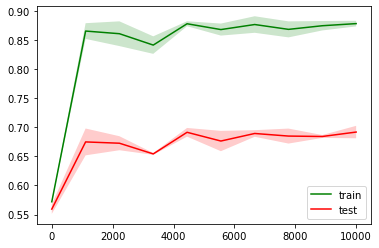

In [37]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [38]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(), svm_params2, n_jobs = -1, cv = skf, return_train_score = True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 14s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [39]:
print(f"{svm_grid_searcher2.best_params_}. Score: {svm_grid_searcher2.best_score_}")

{'C': 0.06989655172413793}. Score: 0.7641204881291982


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

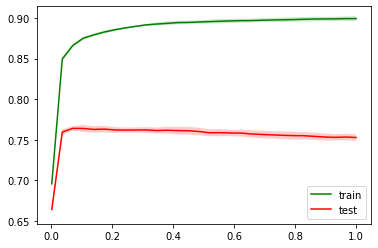

In [40]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [41]:
svm_best = svm_grid_searcher2.best_estimator_
svm_cv_acc = accuracy_score(svm_best.predict(X_valid), y_valid)
svm_cv_acc

0.77767243422612

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [42]:
cv_scores = cross_val_score(svm_best, X_train, y_train)

In [92]:
print(str([round(v, 3) for v in cv_scores])[1:-1])

0.767, 0.771, 0.765, 0.767, 0.776


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [136]:
import time

def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    
    ts1 = time.time()
    
    with open(path_to_X_pickle, 'rb') as file:
        X = pickle.load(file)
    with open(path_to_y_pickle, 'rb') as file:
        y = pickle.load(file)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = test_size, random_state = random_state)

    cv_score = cross_val_score(estimator, X_train, y_train, cv = cv).mean()
    
    estimator.fit(X_train, y_train)
    valid_score = estimator.score(X_valid, y_valid)
    
    ts2 = time.time()
    
    return cv_score, valid_score, round(ts2 - ts1, 2)

**Убедитесь, что функция работает.**

In [77]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s10_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s10_w10.pkl'), skf, random_state=17, test_size=0.3)

(0.7643243901836531, 0.8336098601564351, 1.57)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [64]:
# виконав вручну

# !cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [110]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                                     'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                                     'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv_score, valid_score, time_span = model_assessment(estimator, 
                                                       path_to_X_pkl, 
                                                       path_to_y_pkl, 
                                                       skf, 
                                                       random_state=17, 
                                                       test_size=0.3)
        print(f"s{session_length} w{window_size}: cv_score - {cv_score}, valid_score - {valid_score}. ({time_span}s)")

s15 w10: cv_score - 0.8216825811583321, valid_score - 0.8639488030338943. (1.94s)
s10 w10: cv_score - 0.7643243901836531, valid_score - 0.8336098601564351. (1.07s)
s15 w7: cv_score - 0.8420344312232876, valid_score - 0.8697527791604447. (2.63s)
s10 w7: cv_score - 0.7956614134444934, valid_score - 0.8403849344615895. (1.47s)
s7 w7: cv_score - 0.7475104889454439, valid_score - 0.8048780487804879. (0.94s)
s15 w5: cv_score - 0.8626155587401781, valid_score - 0.8582266477003319. (3.74s)
s10 w5: cv_score - 0.814653159591724, valid_score - 0.8325035561877667. (2.24s)
s7 w5: cv_score - 0.7701449607374445, valid_score - 0.7984826932195354. (1.33s)
s5 w5: cv_score - 0.7217759800769019, valid_score - 0.7625651967757231. (0.87s)
Wall time: 16.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [112]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl')
cv_score, valid_score, time_span = model_assessment(estimator,
                                                     path_to_X_pkl, 
                                                     path_to_y_pkl, 
                                                     skf, 
                                                     random_state=17, 
                                                     test_size=0.3)
print(f"{round(cv_score, 3)} {round(valid_score, 3)}")

0.863 0.858


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [124]:
estimator = LinearSVC(C = svm_grid_searcher2.best_params_['C'])

In [138]:
%%time

for window_size, session_length in tqdm_notebook([(5,5), (7,7), (10,10)]):
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                                     'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                                     'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv_score, valid_score, time_span = model_assessment(estimator, 
                                                       path_to_X_pkl, 
                                                       path_to_y_pkl, 
                                                       skf, 
                                                       random_state=17, 
                                                       test_size=0.3)
        print(f"s{session_length} w{window_size}: cv_score - {cv_score}, valid_score - {valid_score}. ({time_span}s)")

s5 w5: cv_score - 0.40822552133035056, valid_score - 0.41818756996155154. (326.17s)
s7 w7: cv_score - 0.43504284734083704, valid_score - 0.45236229859999316. (346.61s)
s10 w10: cv_score - 0.4606884388597677, valid_score - 0.4787896477913991. (307.17s)

Wall time: 16min 19s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [131]:
%%time
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s15_w5.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s15_w5.pkl')
cv_score, valid_score, time_span = model_assessment(estimator,
                                                     path_to_X_pkl, 
                                                     path_to_y_pkl, 
                                                     skf, 
                                                     random_state=17, 
                                                     test_size=0.3)
print(f"{round(cv_score, 3)} {round(valid_score, 3)}")

Loaded files
Split
cv score
valid score
0.609 0.63
Wall time: 16min 53s


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [153]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s10_w10.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s10_w10.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [311]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [140]:
logit_max_cv_C2

1.5526315789473686

In [157]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs = [logit_max_cv_C2],
                                        cv = skf,
                                        n_jobs = -1,
                                        multi_class = 'ovr',
                                        random_state = 17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 10min 26s


LogisticRegressionCV(Cs=[1.5526315789473686],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

In [163]:
logit_cv_150users.scores_

{6: array([[0.99593445],
        [0.99637217],
        [0.99568413]]),
 13: array([[0.99621591],
        [0.99646599],
        [0.99640344]]),
 15: array([[0.99515261],
        [0.99499609],
        [0.99518374]]),
 16: array([[0.99208782],
        [0.99218139],
        [0.99152463]]),
 28: array([[0.99018014],
        [0.99027365],
        [0.99017983]]),
 31: array([[0.99437078],
        [0.99440188],
        [0.99471462]]),
 33: array([[0.99377658],
        [0.99358874],
        [0.99349492]]),
 39: array([[0.98577058],
        [0.9861767 ],
        [0.98623925]]),
 46: array([[0.99818614],
        [0.99809226],
        [0.99787334]]),
 49: array([[0.99502752],
        [0.99502737],
        [0.99502737]]),
 50: array([[0.99424568],
        [0.99477717],
        [0.99433933]]),
 53: array([[0.99362022],
        [0.99365129],
        [0.99343237]]),
 65: array([[0.99681011],
        [0.99674746],
        [0.99696638]]),
 66: array([[0.99480861],
        [0.99483972],
        [0.994589

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [187]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print(f'User {user_id}, CV score: {cv_scores_by_user[user_id]}')

User 6, CV score: 0.9959969149392668
User 13, CV score: 0.9963617803918484
User 15, CV score: 0.9951108141504879
User 16, CV score: 0.9919312787300928
User 28, CV score: 0.9902112047940047
User 31, CV score: 0.9944957584490166
User 33, CV score: 0.9936200805151687
User 39, CV score: 0.9860621759647857
User 46, CV score: 0.9980505792427459
User 49, CV score: 0.9950274169661647
User 50, CV score: 0.9944540605088948
User 53, CV score: 0.9935679580900166
User 65, CV score: 0.9968413155057849
User 66, CV score: 0.9947459493499458
User 82, CV score: 0.9963930522168405
User 85, CV score: 0.9963617777836896
User 89, CV score: 0.990586494731617
User 92, CV score: 0.9942768410031787
User 100, CV score: 0.9946729759986135
User 102, CV score: 0.9912536738362999
User 103, CV score: 0.9806725959246605
User 105, CV score: 0.996914286900998
User 106, CV score: 0.9947042452154466
User 118, CV score: 0.990878382920628
User 119, CV score: 0.9967266481265694
User 120, CV score: 0.9942247156438478
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [179]:
np.bincount(y_train_150.astype('int')).shape

(2903,)

In [191]:
proportion_by_user = {}
class_distr = np.bincount(y_train_150.astype('int'))

for user_id in np.unique(y_train_150):
    proportion_by_user[user_id] = 1 - class_distr[user_id] / y_train_150.shape[0]
    print(f'User {user_id}, CV score: {cv_scores_by_user[user_id]}, Proportion against all: {proportion_by_user[user_id]}')

User 6, CV score: 0.9959969149392668, Proportion against all: 0.9844046452473781
User 13, CV score: 0.9963617803918484, Proportion against all: 0.9957050226216042
User 15, CV score: 0.9951108141504879, Proportion against all: 0.9944019348247608
User 16, CV score: 0.9919312787300928, Proportion against all: 0.9847173863186206
User 28, CV score: 0.9902112047940047, Proportion against all: 0.9879490440547922
User 31, CV score: 0.9944957584490166, Proportion against all: 0.9944436336342597
User 33, CV score: 0.9936200805151687, Proportion against all: 0.9925463378020557
User 39, CV score: 0.9860621759647857, Proportion against all: 0.9839146842357651
User 46, CV score: 0.9980505792427459, Proportion against all: 0.9971227821445697
User 49, CV score: 0.9950274169661647, Proportion against all: 0.9938285761941497
User 50, CV score: 0.9944540605088948, Proportion against all: 0.9941517419677668
User 53, CV score: 0.9935679580900166, Proportion against all: 0.9920459520880679
User 65, CV score

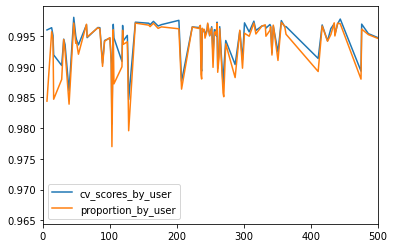

In [295]:
# відобразимо точність по крос валідації та частки відповідних юзерів у всій вибірці
ax = sns.lineplot(x = np.unique(y_train_150).flatten(), y = list(cv_scores_by_user.values()))
sns.lineplot(x = np.unique(y_train_150).flatten(), y = list(proportion_by_user.values()), ax = ax)
ax.legend(['cv_scores_by_user', 'proportion_by_user'])
ax.set_xlim((0, 500));

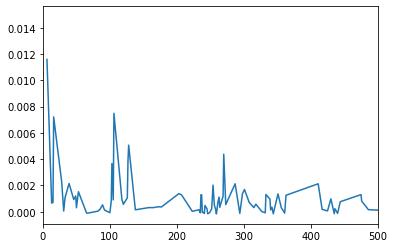

In [296]:
# відобразимо різницю крос валідації та частки відповідних юзерів у всій вибірці
acc_diff_vs_constant = {k: cv_scores_by_user[k] - proportion_by_user[k] for k in cv_scores_by_user}
ax = sns.lineplot(x = np.unique(y_train_150), y = list(acc_diff_vs_constant.values()))
ax.set_xlim((0, 500));

Як видно, різниця у більшості випадків має додатне значення, що вказує на більшу точність моделі ніж просто константний прогноз

In [303]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

130

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [307]:
round(num_better_than_default / len(acc_diff_vs_constant), 3)

0.867

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [348]:
y_binary_128 = y_150users == 128

In [354]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [367]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, 
                                              X_sparse_150users, 
                                              y_binary_128, 
                                              train_sizes = train_sizes, 
                                              cv = skf, 
                                              n_jobs = -1, 
                                              random_state = 17)

Wall time: 15.1 s


In [372]:
train_sizes

array([0.25      , 0.28947368, 0.32894737, 0.36842105, 0.40789474,
       0.44736842, 0.48684211, 0.52631579, 0.56578947, 0.60526316,
       0.64473684, 0.68421053, 0.72368421, 0.76315789, 0.80263158,
       0.84210526, 0.88157895, 0.92105263, 0.96052632, 1.        ])

In [374]:
X_sparse_150users.shape

(137038, 27797)

In [369]:
n_train

array([22839, 26445, 30051, 33658, 37264, 40870, 44476, 48083, 51689,
       55295, 58901, 62508, 66114, 69720, 73326, 76933, 80539, 84145,
       87751, 91358])

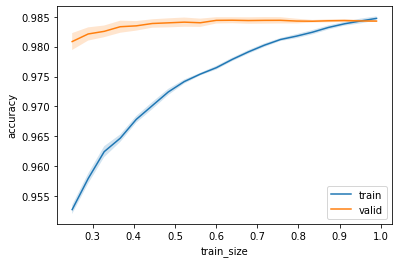

In [366]:
plot_learning_curve(val_train, val_test, train_sizes, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.